In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from analyze_utilities import *
from dataset_utilities import create_cifar10_dataloaders
import pandas as pd
import copy

def load_dict_from_file_list(files):
    result_dict = {}
    for file in files:
        with open(file) as data_file:    
            result_dict.update(json.load(data_file)) 
    return result_dict

# Load Results

In [2]:
#------
# Emipircal Risk Minimization (ERM)
files = ['../output/ERM_results_20180813_204946/results_ERM_20180813_204946.json'] # 0-10,000
results_dict_ERM = load_dict_from_file_list(files)
print('NML: loaded %d keys' % len(results_dict_ERM))

#------
# CIFAR 10 : Normalized Maximum Likelihood with test samples from CIFAR 10    
files = ['../output/NML_results_20180820_084237/results_NML_20180820_084237.json', # 000-099
         '../output/NML_results_20180815_135021/results_NML_20180815_135021.json', # 100-199
         '../output/NML_results_20180815_134312/results_NML_20180815_134312.json', # 200-299
         '../output/NML_results_20180815_134318/results_NML_20180815_134318.json', # 300-399
         '../output/NML_results_20180815_134413/results_NML_20180815_134413.json', # 400-499
         '../output/NML_results_20180815_134420/results_NML_20180815_134420.json', # 500-599
         '../output/NML_results_20180815_134427/results_NML_20180815_134427.json', # 600-699
         '../output/NML_results_20180815_134449/results_NML_20180815_134449.json', # 700-799
         '../output/NML_results_20180815_134501/results_NML_20180815_134501.json', # 800-899
         '../output/NML_results_20180815_134527/results_NML_20180815_134527.json'] # 900-999
results_dict_NML = load_dict_from_file_list(files)
print('NML: loaded %d keys' % len(results_dict_NML))

#------
# CIFAR 100: Normalized Maximum Likelihood with Cifar 10 trainset and test samples from CIFAR 100
files = ['../output/OutOfDist_CIFR100_results_20180813_153916/results_OutOfDist_CIFR100_20180813_153916.json', # 00-24
         '../output/OutOfDist_CIFR100_results_20180814_150859/results_OutOfDist_CIFR100_20180814_150859.json'] # 25-99
results_dict_CIFAR100 = load_dict_from_file_list(files)
print('CIFAR100: loaded %d keys' % len(results_dict_CIFAR100))

#------
# Noise: Normalized Maximum Likelihood with Cifar 10 trainset and Noise images test samples
files = ['../output/OutOfDist_Noise_results_20180813_153950/results_OutOfDist_Noise_20180813_153950.json',  # 00-24
         '../output/OutOfDist_Noise_results_20180814_150915/results_OutOfDist_Noise_20180814_150915.json' ] # 25-100
results_dict_Noise = load_dict_from_file_list(files)
print('Noise: loaded %d keys' % len(results_dict_Noise))

NML: loaded 10000 keys
NML: loaded 1000 keys
CIFAR100: loaded 100 keys
Noise: loaded 100 keys


# Visualize Out of Distribution
Plot histogram of the normalization factor from based on 
1. cifar10 dataset
2. cifar 100 dataset
3. Noise images

In [3]:
# Extract and plot normalization factor
_, normalization_factor_CIFAR10_list, _, _, _ = get_NML_log_loss_from_dict(results_dict_NML)
_, normalization_factor_CIFAR100_list, _, _, _  = get_NML_log_loss_from_dict(results_dict_CIFAR100)
_, normalization_factor_Noise_list, _, _, _ = get_NML_log_loss_from_dict(results_dict_Noise)

log_normalization_factor_CIFAR10_list = np.log10(normalization_factor_CIFAR10_list)
log_normalization_factor_CIFAR100_list = np.log10(normalization_factor_CIFAR100_list)
log_normalization_factor_Noise_list = np.log10(normalization_factor_Noise_list).tolist()

# Print the mean
print('log10(NormalizationFactor): [cifar10 cifar100 Noise]=[%f %f %f] ' % 
      (np.mean(log_normalization_factor_CIFAR10_list), 
       np.mean(log_normalization_factor_CIFAR100_list), 
       np.mean(log_normalization_factor_Noise_list)))

log10(NormalizationFactor): [cifar10 cifar100 Noise]=[0.227915 0.540402 0.743275] 


<Figure size 432x288 with 0 Axes>

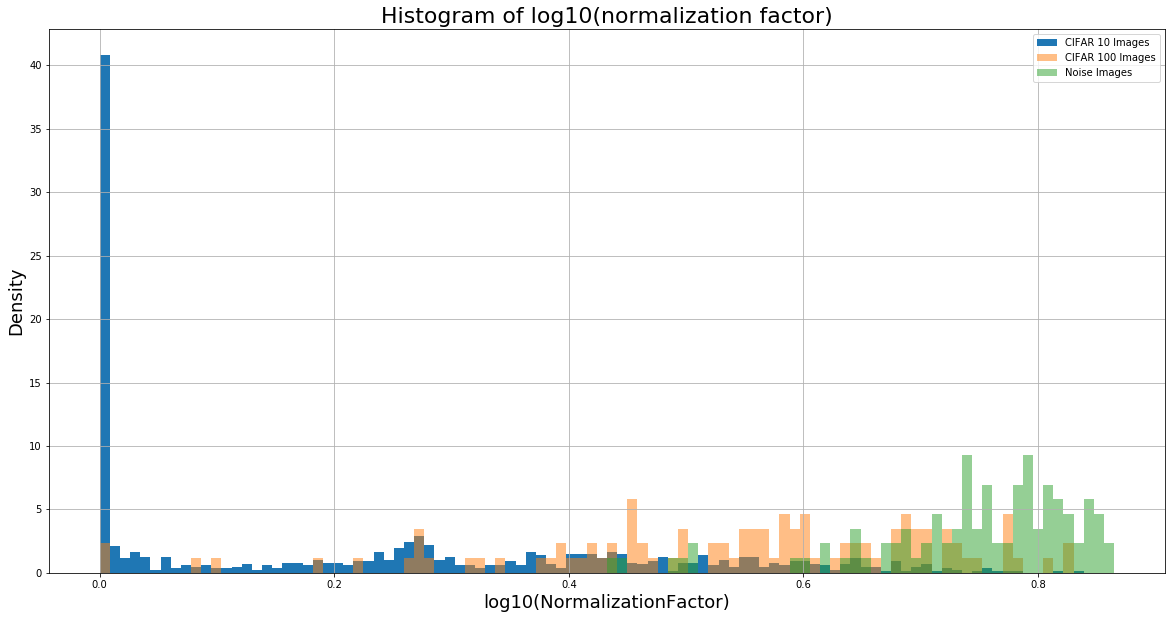

In [4]:
# Initalize joint bins
bins = 100
n, bins, patches = plt.hist([log_normalization_factor_CIFAR10_list,
                             log_normalization_factor_CIFAR100_list,
                             log_normalization_factor_Noise_list], alpha=1, density=True,
                            label=['CIFAR 10 Image', 'CIFAR 100 Image', 'Noise Image'], bins=bins)
plt.gcf().clear()

# Plot
plt.figure(figsize=(20,10))
plt.hist(log_normalization_factor_CIFAR10_list, alpha=1, density=True, label='CIFAR 10 Images', bins=bins)
plt.hist(log_normalization_factor_CIFAR100_list, alpha=0.5, density=True, label='CIFAR 100 Images', bins=bins)
plt.hist(log_normalization_factor_Noise_list, alpha=0.5, density=True, label='Noise Images', bins=bins)

plt.ylabel('Density', fontsize=18)
plt.xlabel('log10(NormalizationFactor)', fontsize=18)
plt.title('Histogram of log10(normalization factor)', fontsize=22)
plt.grid()
plt.legend()
plt.show()

# Visualize the Loss of the Different Methods
1. Empiriical Risk Minimization (ERM)
2. Normalized Maximum Likelihood (NML)
3. Jinni- model which was trained real label of the test sample

In [5]:
# Extract from dict
loss_NML_list, normalization_factor_NML_list, acc_NML, is_correct_NML_list, _ = get_NML_log_loss_from_dict(results_dict_NML)
loss_ERM_list, acc_ERM, is_correct_ERM_list = get_ERM_log_loss_from_dict(results_dict_NML)
loss_Jinni_list, acc_Jinni = get_jinni_log_loss_from_dict(results_dict_NML)

# Print acc and mean loss
statistics = {'Jinni': pd.Series([acc_Jinni,  np.mean(loss_Jinni_list), np.std(loss_Jinni_list)], 
                                 index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'NML' : pd.Series([acc_NML,  np.mean(loss_NML_list), np.std(loss_NML_list)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([acc_ERM,  np.mean(loss_ERM_list), np.std(loss_ERM_list)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())

                      Jinni       NML       ERM
Acc                0.993000  0.913000  0.920000
Mean Loss (log10)  0.015735  0.243650  0.202926
Std Loss (log10)   0.125907  0.273949  0.866917


<Figure size 432x288 with 0 Axes>

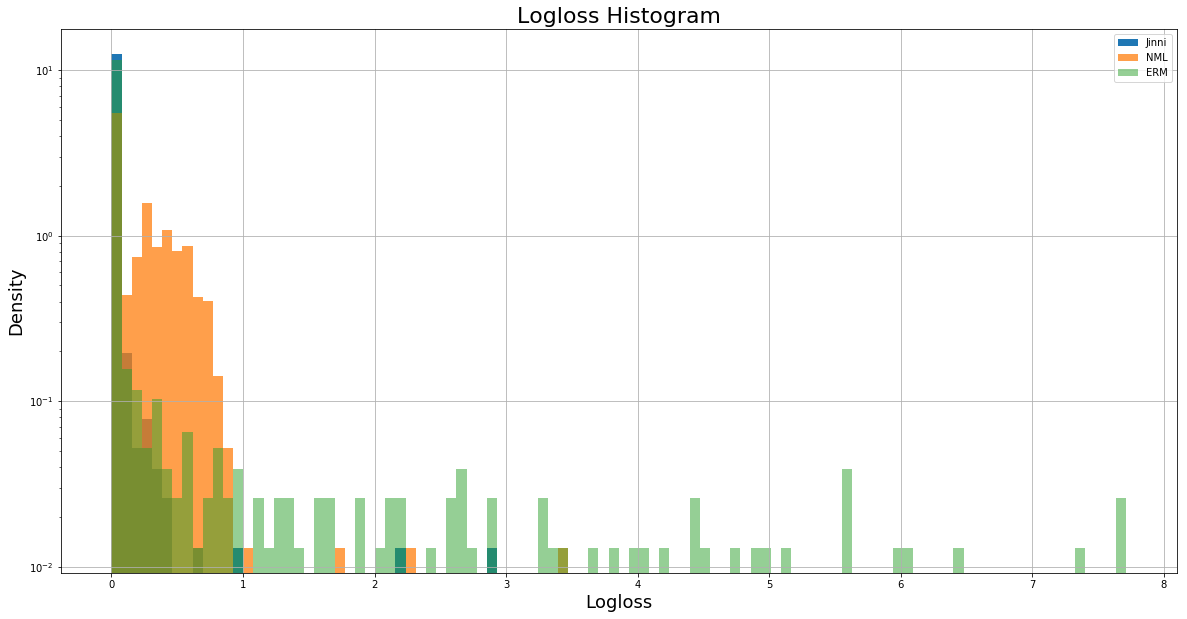

In [6]:
# Initalize joint bins
bins = 100
n, bins, patches = plt.hist([loss_NML_list, loss_Jinni_list, loss_ERM_list], bins=bins, alpha=1, label=['NML', 'Jinni', 'ERM'], density=True)
plt.gcf().clear()

# Plot
plt.figure(figsize=(20,10))
plt.hist(loss_Jinni_list, bins=bins, alpha=1, label='Jinni', density=True)
plt.hist(loss_NML_list, bins=bins, alpha=0.75, label='NML', density=True)
plt.hist(loss_ERM_list, bins=bins, alpha=0.5, label='ERM', density=True)
plt.ylabel('Density', fontsize=18)
plt.xlabel('Logloss', fontsize=18)
plt.title('Logloss Histogram', fontsize=22)
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [7]:
#  Construct best loss based on normalization factor
log10_normalization_factor_list = np.log10(normalization_factor_NML_list)
statistics = {'Jinni': pd.Series(loss_Jinni_list, index=log10_normalization_factor_list),
              'NML' : pd.Series(loss_NML_list, index=log10_normalization_factor_list),
              'ERM' :pd.Series(loss_ERM_list, index=log10_normalization_factor_list),
              'NML_is_true' :pd.Series(is_correct_NML_list, index=log10_normalization_factor_list)}
df = pd.DataFrame(statistics)
df = df.sort_index()

threshold_list = np.linspace(0,1,99)
loss_list = []
acc_list = []
acc_size_list = []
nml_solo_list = []
for threshold in threshold_list:
    
    # loss: erm and nml
    loss = np.concatenate(( df[df.index<= threshold]['ERM'].values, df[df.index>  threshold]['NML'].values)).mean()
    loss_list.append(loss)
    
    # loss: erm and nml
    loss_nml_solo = df[df.index<= threshold]['NML'].values.mean()
    nml_solo_list.append(loss_nml_solo)
    
    # Acc
    is_true_values =  df[df.index<= threshold]['NML_is_true'].values.astype(int)
    acc = is_true_values.mean()
    acc_list.append(acc)
    
    acc_size = is_true_values.shape[0] / float(df['NML_is_true'].values.shape[0])
    acc_size_list.append(acc_size)  

/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: Mean of empty slice.
/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: Mean of empty slice.
/Users/kobibi/anaconda3/envs/pt36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


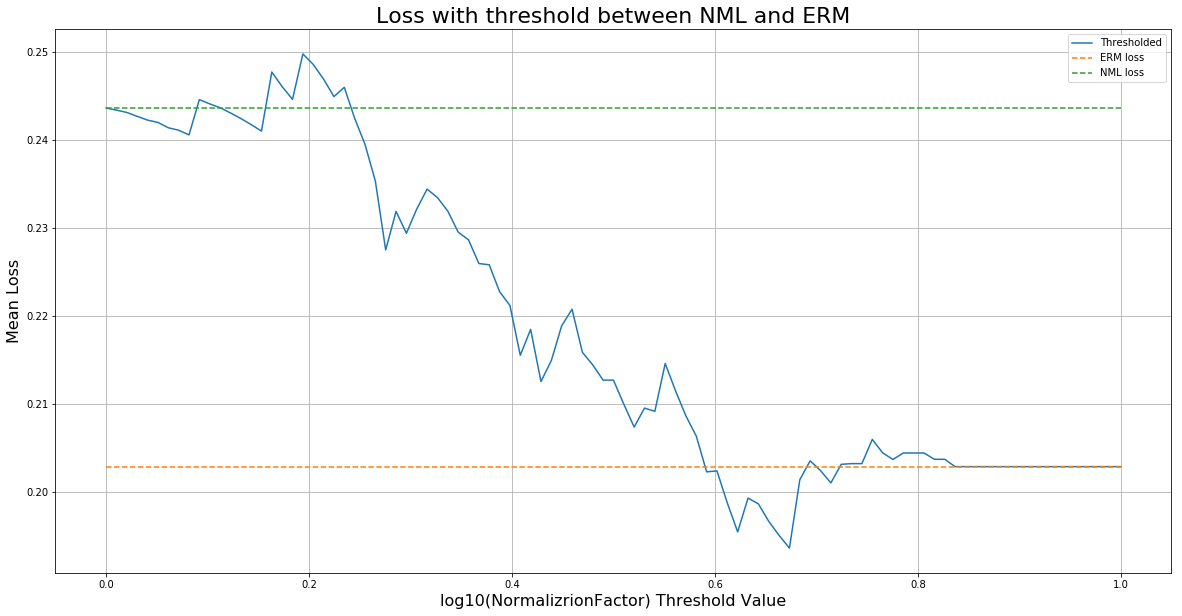

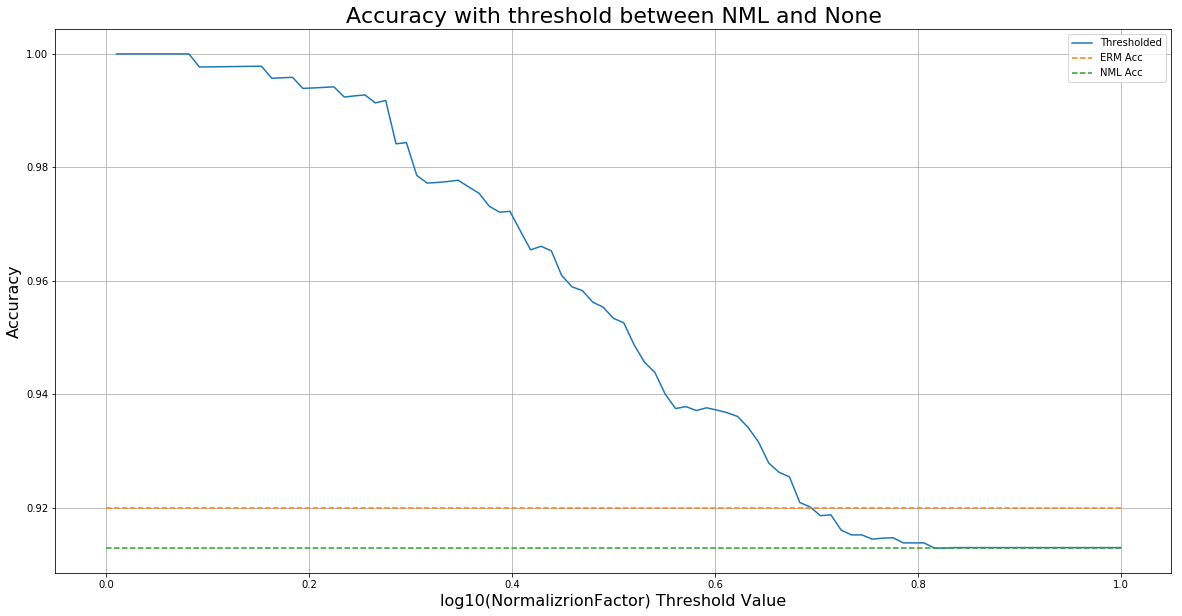

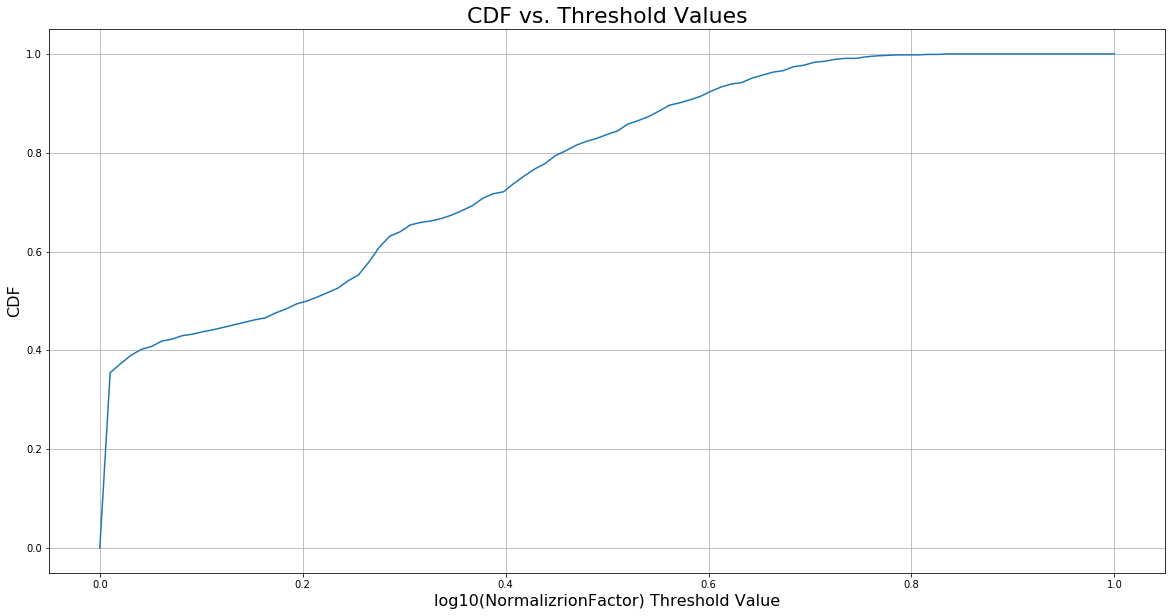

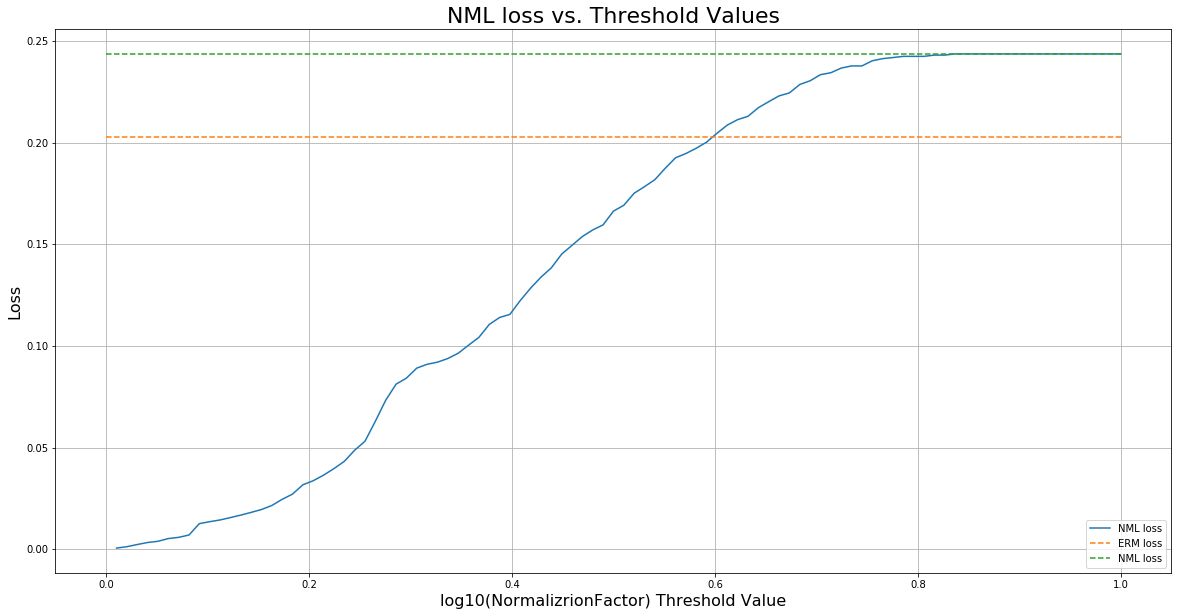

In [8]:
# Plot Loss
plt.figure(figsize=(20,10))
plt.plot(threshold_list, loss_list, label='Thresholded')
plt.plot(threshold_list, list(np.mean(loss_ERM_list)*np.ones([len(threshold_list)])), '--', label='ERM loss')
plt.plot(threshold_list, list(np.mean(loss_NML_list)*np.ones([len(threshold_list)])), '--', label='NML loss')
plt.grid()
plt.legend()
plt.xlabel('log10(NormalizrionFactor) Threshold Value', fontsize=16)
plt.ylabel('Mean Loss', fontsize=16)
plt.title('Loss with threshold between NML and ERM', fontsize=22)
plt.show()

# Plot Acc
plt.figure(figsize=(20,10))
plt.plot(threshold_list, acc_list, label='Thresholded')
plt.plot(threshold_list, list(acc_ERM*np.ones([len(threshold_list)])), '--', label='ERM Acc')
plt.plot(threshold_list, list(acc_NML*np.ones([len(threshold_list)])), '--', label='NML Acc')
plt.grid()
plt.legend()
plt.xlabel('log10(NormalizrionFactor) Threshold Value', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy with threshold between NML and None', fontsize=22)
plt.show()

# Plot Acc CDF
plt.figure(figsize=(20,10))
plt.plot(threshold_list, acc_size_list, label='Threshold Acc CDF')
plt.grid()
plt.xlabel('log10(NormalizrionFactor) Threshold Value', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.title('CDF vs. Threshold Values', fontsize=22)
plt.show()


# Plot Acc CDF
plt.figure(figsize=(20,10))
plt.plot(threshold_list, nml_solo_list, label='NML loss')
plt.plot(threshold_list, list(np.mean(loss_ERM_list)*np.ones([len(threshold_list)])), '--', label='ERM loss')
plt.plot(threshold_list, list(np.mean(loss_NML_list)*np.ones([len(threshold_list)])), '--', label='NML loss')
plt.grid()
plt.xlabel('log10(NormalizrionFactor) Threshold Value', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('NML loss vs. Threshold Values', fontsize=22)
plt.legend()
plt.show()

# Correct vs Incorrect

Correct = 913, Incorrect = 87 


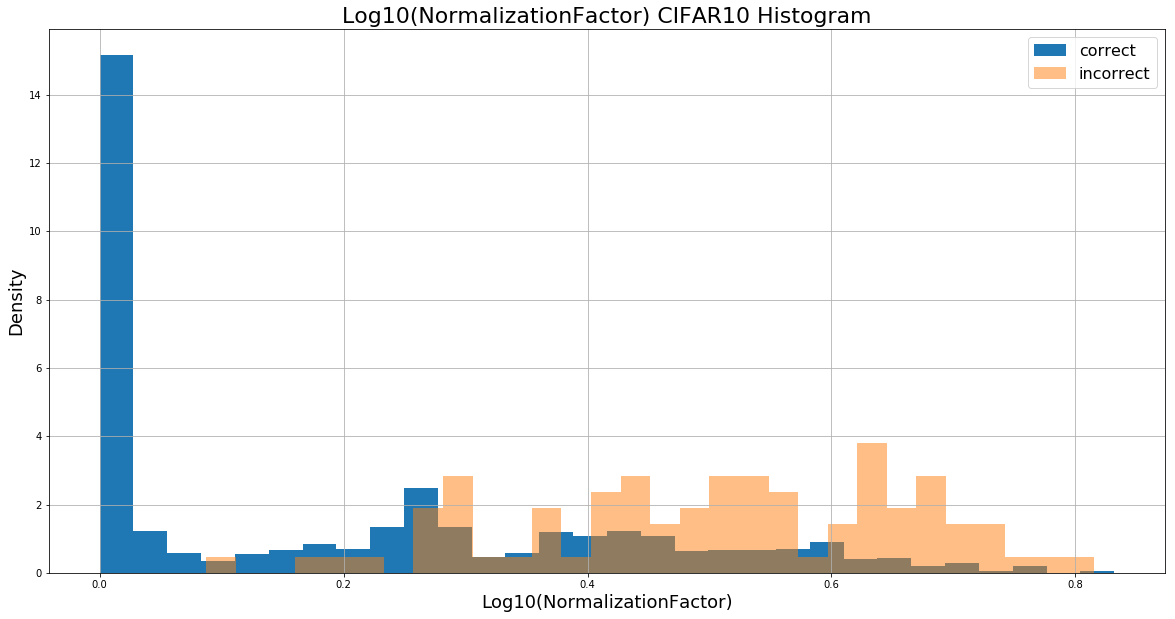

In [9]:
# Plot params
plt.figure(figsize=(20,10))
bins= 30

# Rename
log_normalization_factor_CIFAR10_list = np.log10(np.array(normalization_factor_NML_list))
is_correct_list = is_correct_NML_list

correct =  log_normalization_factor_CIFAR10_list[np.array(is_correct_list)]
incorrect =  log_normalization_factor_CIFAR10_list[~np.array(is_correct_list)]
print('Correct = %d, Incorrect = %d '% (correct.shape[0], incorrect.shape[0]))

# Plot
plt.hist(correct, alpha=1, bins=bins, density=True, label='correct')
plt.hist(incorrect, alpha=0.5, bins=bins, density=True, label='incorrect')
plt.ylabel('Density', fontsize=18)
plt.xlabel('Log10(NormalizationFactor)', fontsize=18)
plt.title('Log10(NormalizationFactor) CIFAR10 Histogram', fontsize=22)
plt.grid()
plt.legend(loc=1, prop={'size': 16})
plt.show()

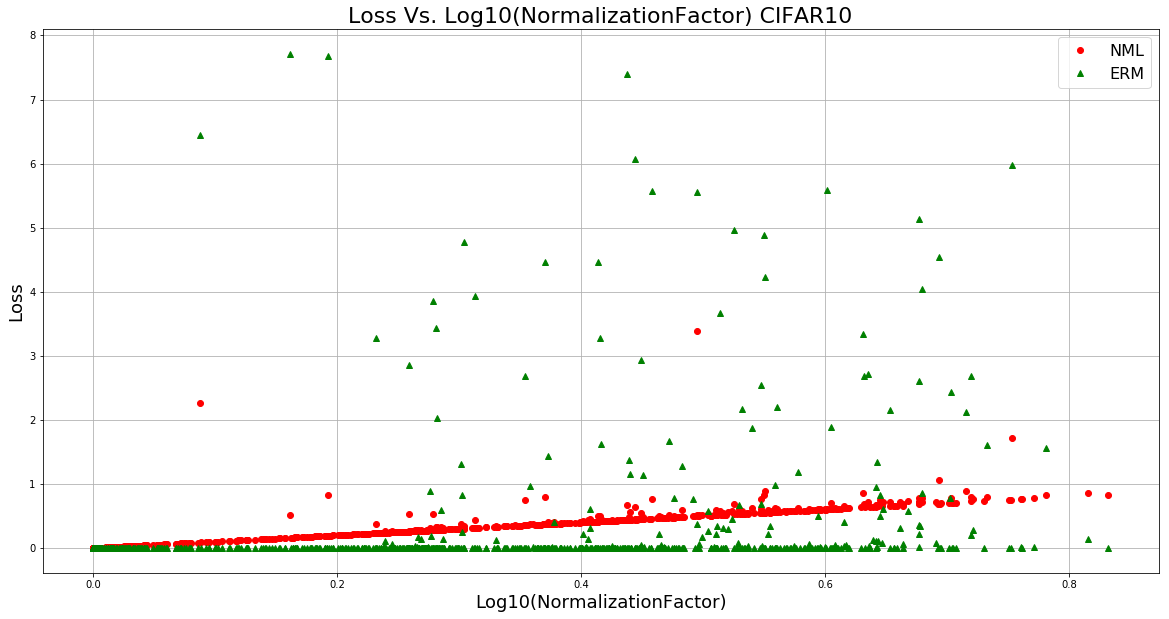

In [10]:
# Plot params
plt.figure(figsize=(20,10))

# Plot
plt.plot(list(log_normalization_factor_CIFAR10_list), loss_NML_list, 'ro', label='NML')
plt.plot(list(log_normalization_factor_CIFAR10_list), loss_ERM_list, 'g^', label='ERM')
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Log10(NormalizationFactor)', fontsize=18)
plt.title('Loss Vs. Log10(NormalizationFactor) CIFAR10', fontsize=22)
plt.grid()
plt.legend(loc=1, prop={'size': 16})
plt.show()

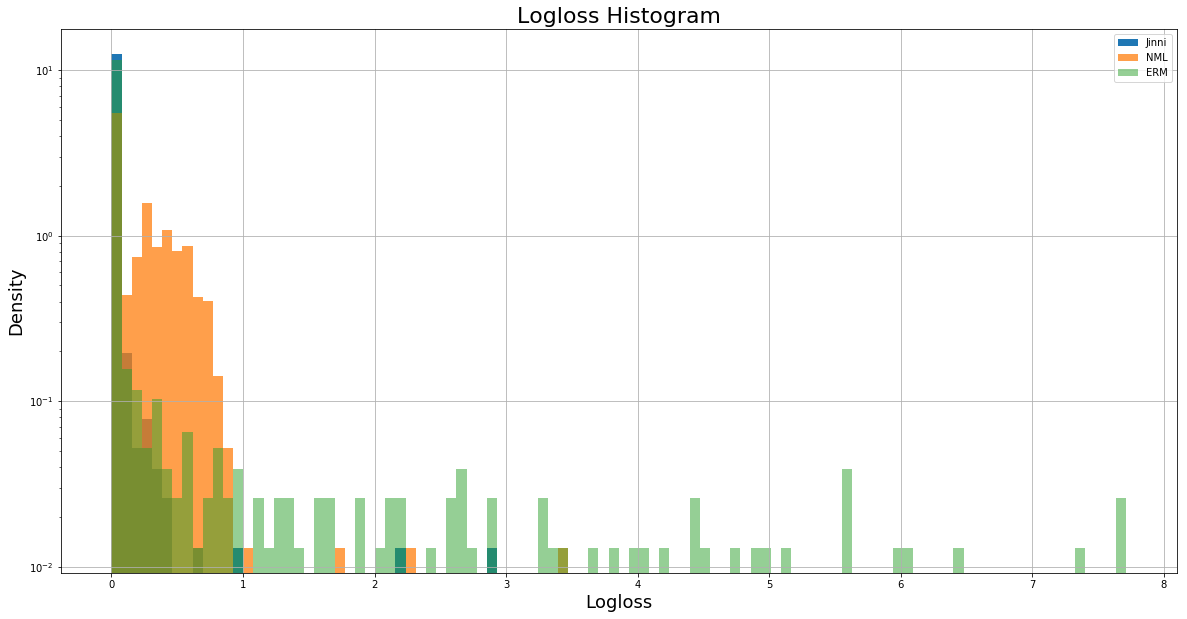

In [11]:
# Plot
bins= 100
plt.figure(figsize=(20,10))
n, bins, patches = plt.hist([loss_NML_list, loss_Jinni_list, loss_ERM_list], bins=bins, alpha=1, label=['NML', 'Jinni', 'ERM'], density=True)
plt.gcf().clear()
plt.hist(loss_Jinni_list, bins=bins, alpha=1, label='Jinni', density=True)
plt.hist(loss_NML_list, bins=bins, alpha=0.75, label='NML', density=True)
plt.hist(loss_ERM_list, bins=bins, alpha=0.5, label='ERM', density=True)
plt.ylabel('Density', fontsize=18)
plt.xlabel('Logloss', fontsize=18)
plt.title('Logloss Histogram', fontsize=22)
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

# Log loss of the series

In [12]:
# Extract from dict
loss_NML_series_list, normalization_factor_NML_series_list, acc_NML_series, is_correct_NML_series_list, _ = \
    get_NML_log_loss_of_the_series_from_dict(results_dict_NML)
loss_ERM_list, acc_ERM, is_correct_ERM_list = get_ERM_log_loss_from_dict(results_dict_NML)
loss_Jinni_list, acc_Jinni = get_jinni_log_loss_from_dict(results_dict_NML)

# Print acc and mean loss
statistics = {'Jinni': pd.Series([acc_Jinni,  np.mean(loss_Jinni_list), np.std(loss_Jinni_list)], 
                                 index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'NML Series' : pd.Series([acc_NML_series,  np.mean(loss_NML_series_list), np.std(loss_NML_series_list)],
                                index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)']),
              'ERM' :pd.Series([acc_ERM,  np.mean(loss_ERM_list), np.std(loss_ERM_list)],
                               index=['Acc', 'Mean Loss (log10)', 'Std Loss (log10)'])}
print(pd.DataFrame(statistics).to_string())

                      Jinni  NML Series       ERM
Acc                0.993000    0.873000  0.920000
Mean Loss (log10)  0.015735    0.155159  0.202926
Std Loss (log10)   0.125907    0.320489  0.866917


In [13]:
print(np.mean(loss_NML_list), np.mean(loss_NML_series_list))
# for i in range(len(loss_NML_series_list)):
#     print(loss_NML_list[i], loss_NML_series_list[i])

0.24364970049515886 0.15515924660265717


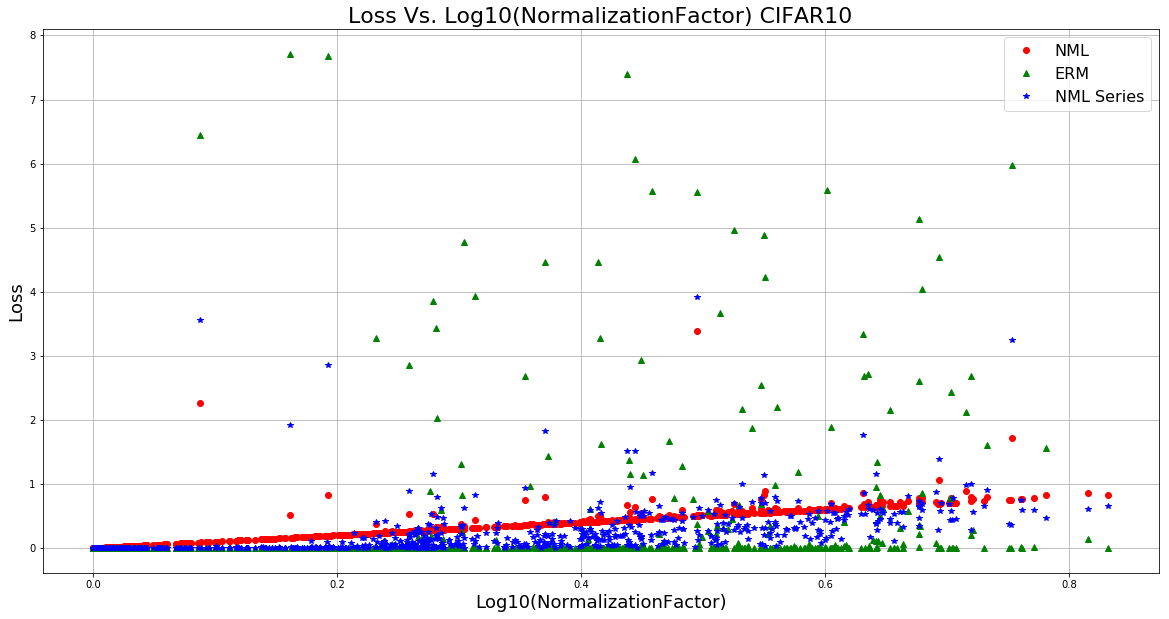

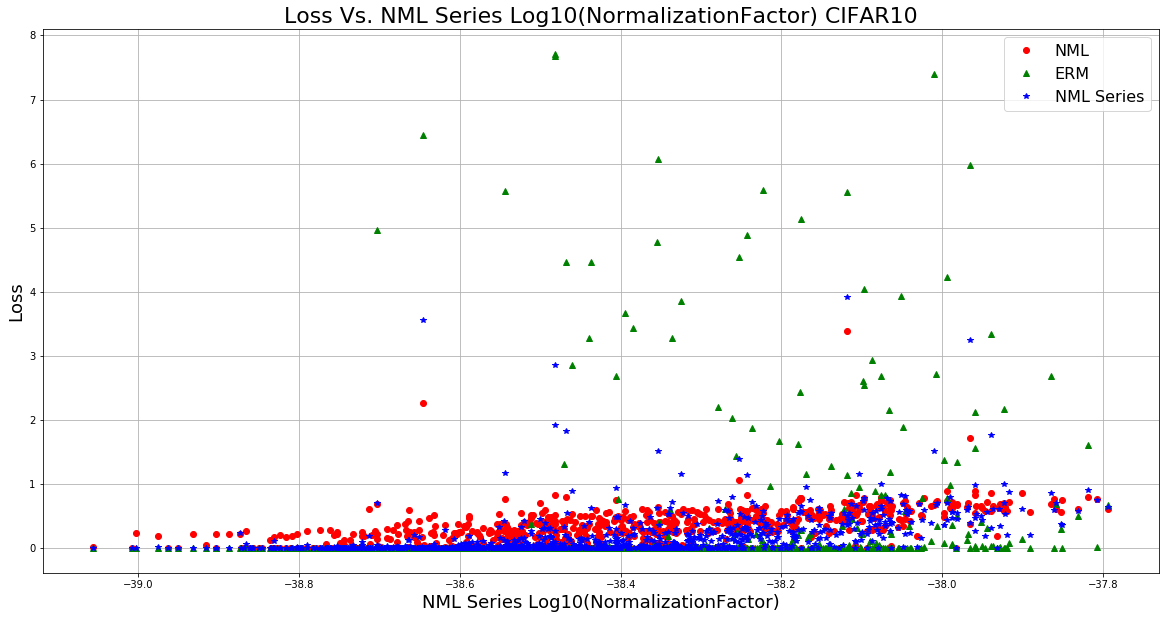

In [14]:
# Plot: Loss vs. NML nomralization factor
plt.figure(figsize=(20,10))
plt.plot(list(log_normalization_factor_CIFAR10_list), loss_NML_list, 'ro', label='NML')
plt.plot(list(log_normalization_factor_CIFAR10_list), loss_ERM_list, 'g^', label='ERM')
plt.plot(list(log_normalization_factor_CIFAR10_list), loss_NML_series_list, 'b*', label='NML Series')
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Log10(NormalizationFactor)', fontsize=18)
plt.title('Loss Vs. Log10(NormalizationFactor) CIFAR10', fontsize=22)
plt.grid()
plt.legend(loc=1, prop={'size': 16})
plt.show()

# Plot: Loss vs. NML series nomralization factor
plt.figure(figsize=(20,10))
log_normalization_factor_NML_series_list = np.log10(normalization_factor_NML_series_list)
plt.plot(list(log_normalization_factor_NML_series_list), loss_NML_list, 'ro', label='NML')
plt.plot(list(log_normalization_factor_NML_series_list), loss_ERM_list, 'g^', label='ERM')
plt.plot(list(log_normalization_factor_NML_series_list), loss_NML_series_list, 'b*', label='NML Series')
plt.ylabel('Loss', fontsize=18)
plt.xlabel('NML Series Log10(NormalizationFactor)', fontsize=18)
plt.title('Loss Vs. NML Series Log10(NormalizationFactor) CIFAR10', fontsize=22)
plt.grid()
plt.legend(loc=1, prop={'size': 16})
plt.show()

# Visualize Specific Sample

In [15]:
# Load CIFAR10 dataset
trainloader, testloader, classes =  create_cifar10_dataloaders('../data', 1, 1)

idx = 150
prob_jinni, true_label, predicted_jinni_label = extract_jinni_probabilities_list(results_dict_NML[str(idx)])
loss_jinni = compute_log_loss(prob_jinni, true_label)
print(prob_jinni)
print('Loss: %f, [true predicted]=[%f %f], [%s %s]' % 
      (loss_jinni, true_label, predicted_jinni_label, classes[true_label], classes[predicted_jinni_label]))

Files already downloaded and verified
Files already downloaded and verified
[1.476255079069233e-06, 6.152798825986849e-10, 2.807669895188436e-11, 1.9499999488400976e-14, 1.301319989266414e-11, 4.99999991225835e-15, 1.2489999540264002e-13, 1.1700000031853765e-14, 0.9999986290931702, 1.3888899579039826e-11]
Loss: 0.000001, [true predicted]=[8.000000 8.000000], [ship ship]


Sowing test sample 150
8
('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


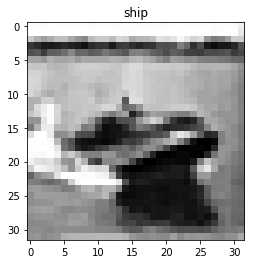

In [16]:
# Show Sample
idx = 150
print('Sowing test sample %d' % idx)
data = testloader.dataset.test_data[idx]
label = testloader.dataset.test_labels[idx]
plt.imshow(data)
plt.title(classes[label])
print(label)
print(classes)

# Random labels

In [30]:
#------
# Random Labels: cifar10 labels are random - Resnet20

# # Random probalility 1.0
# files = ['../output/Random_Labels_results_20180921_195514/results_Random_Labels_20180921_195514.json'] # 0-99
# results_dict_Random_7 = load_dict_from_file_list(files)
# print('Random P=1.0: loaded %d keys' % len(results_dict_Random_7))

# # Random probalility 0.6
# files = ['../output/Random_Labels_results_20180921_195505/results_Random_Labels_20180921_195505.json'] # 0-99
# results_dict_Random_6 = load_dict_from_file_list(files)
# print('Random P=0.6: loaded %d keys' % len(results_dict_Random_6))

# # Random probalility 0.5
# files = ['../output/Random_Labels_results_20180921_195456/results_Random_Labels_20180921_195456.json'] # 0-99
# results_dict_Random_5 = load_dict_from_file_list(files)
# print('Random P=0.5: loaded %d keys' % len(results_dict_Random_5))

# # Random probalility 0.3
# files = ['../output/Random_Labels_results_20180921_195449/results_Random_Labels_20180921_195449.json'] # 0-99
# results_dict_Random_4 = load_dict_from_file_list(files)
# print('Random P=0.3: loaded %d keys' % len(results_dict_Random_4))

# # Random probalility 0.1
# files = ['../output/Random_Labels_results_20180921_195442/results_Random_Labels_20180921_195442.json'] # 0-99
# results_dict_Random_3 = load_dict_from_file_list(files)
# print('Random P=0.1: loaded %d keys' % len(results_dict_Random_3))

# # Random probalility 0.03
# files = ['../output/Random_Labels_results_20180921_195434/results_Random_Labels_20180921_195434.json'] # 0-99
# results_dict_Random_2 = load_dict_from_file_list(files)
# print('Random P=0.03: loaded %d keys' % len(results_dict_Random_2))

# # Random probalility 0.01
# files = ['../output/Random_Labels_results_20180921_195427/results_Random_Labels_20180921_195427.json'] # 0-99
# results_dict_Random_1 = load_dict_from_file_list(files)
# print('Random P=0.01: loaded %d keys' % len(results_dict_Random_1))

# # Random probalility 0.0
# files = ['../output/Random_Labels_results_20180921_195322/results_Random_Labels_20180921_195322.json'] # 0-99
# results_dict_Random_0 = load_dict_from_file_list(files)
# print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# random_prob = [0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]

#------
# Random Labels: cifar10 labels are random - Wide Resnet

# Random probalility 0.0
files = ['../output/Random_Labels_results_20180929_134314/results_Random_Labels_20180929_134314.json'] # 0-99
results_dict_Random_0 = load_dict_from_file_list(files)
print('Random P=0.0: loaded %d keys' % len(results_dict_Random_0))

# Random probalility 0.01
files = ['../output/Random_Labels_results_20180929_134306/results_Random_Labels_20180929_134306.json'] # 0-99
results_dict_Random_1 = load_dict_from_file_list(files)
print('Random P=0.01: loaded %d keys' % len(results_dict_Random_1))

# Random probalility 0.03
files = ['../output/Random_Labels_results_20180929_134258/results_Random_Labels_20180929_134258.json'] # 0-99
results_dict_Random_2 = load_dict_from_file_list(files)
print('Random P=0.03: loaded %d keys' % len(results_dict_Random_2))

# Random probalility 0.1
files = ['../output/Random_Labels_results_20180929_134250/results_Random_Labels_20180929_134250.json'] # 0-99
results_dict_Random_3 = load_dict_from_file_list(files)
print('Random P=0.1: loaded %d keys' % len(results_dict_Random_3))

# Random probalility 0.3
files = ['../output/Random_Labels_results_20180929_134243/results_Random_Labels_20180929_134243.json'] # 0-99
results_dict_Random_4 = load_dict_from_file_list(files)
print('Random P=0.3: loaded %d keys' % len(results_dict_Random_4))

# Random probalility 0.5
files = ['../output/Random_Labels_results_20180929_134236/results_Random_Labels_20180929_134236.json'] # 0-99
results_dict_Random_5 = load_dict_from_file_list(files)
print('Random P=0.5: loaded %d keys' % len(results_dict_Random_5))

# Random probalility 0.6
files = ['../output/Random_Labels_results_20180929_134229/results_Random_Labels_20180929_134229.json'] # 0-99
results_dict_Random_6 = load_dict_from_file_list(files)
print('Random P=0.6: loaded %d keys' % len(results_dict_Random_6))

# Random probalility 1.0
files = ['../output/Random_Labels_results_20180929_134102/results_Random_Labels_20180929_134102.json'] # 0-99
results_dict_Random_7 = load_dict_from_file_list(files)
print('Random P=1.0: loaded %d keys' % len(results_dict_Random_7))

random_prob = [0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]

Random P=0.0: loaded 78 keys
Random P=0.01: loaded 77 keys
Random P=0.03: loaded 78 keys
Random P=0.1: loaded 76 keys
Random P=0.3: loaded 78 keys
Random P=0.5: loaded 76 keys
Random P=0.6: loaded 78 keys
Random P=1.0: loaded 78 keys


In [31]:
from wide_resnet import WideResNet
from resnet import resnet20
model = WideResNet()
wide_resnet_params = sum(p.numel() for p in model.parameters())
model = resnet20()
resnet20_params = sum(p.numel() for p in model.parameters())
print('[WideResnet Resnet20]=[{} {}]'.format(wide_resnet_params, resnet20_params))

[WideResnet Resnet20]=[369498 269722]


In [43]:
# Extract normalization factor
result_dict_list = [results_dict_Random_0, results_dict_Random_1, results_dict_Random_2, results_dict_Random_3,
                    results_dict_Random_4, results_dict_Random_4, results_dict_Random_6, results_dict_Random_7]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
for results_dict in result_dict_list:
    _, norm_factor_list, _, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())

loss, _, acc  = get_ERM_log_loss_from_dict(results_dict_Random_0)
print('log10(NormalizationFactor): Prob2beRandom={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))

log10(NormalizationFactor): Prob2beRandom=[0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]=[0.931 0.94  0.96  0.982 0.985 0.985 0.991 0.981]


In [45]:
print(loss, np.sum(acc==True))

[5.1771939632926655e-08, 4.607726804350119e-06, 0.9325072838990024, -9.64327466553287e-17, 0.002260774992634669, -9.64327466553287e-17, -9.64327466553287e-17, -9.64327466553287e-17, -9.64327466553287e-17, 1.2942986079889856e-07, -9.64327466553287e-17, -9.64327466553287e-17, 0.0032316126319740053, -9.64327466553287e-17, 1.0354388553398332e-07, -9.64327466553287e-17, -9.64327466553287e-17, 3.917561244593952, 1.8268144693384434, 0.004862829382568385, -9.64327466553287e-17, -9.64327466553287e-17, -9.64327466553287e-17, 3.5981645021267135e-06, 0.00011173821242423053, -9.64327466553287e-17, 0.00014723845808474822, 2.561520139332585, -9.64327466553287e-17, 5.070938515689259, -9.64327466553287e-17, 4.73246087662641, -9.64327466553287e-17, -9.64327466553287e-17, -9.64327466553287e-17, -9.64327466553287e-17, -9.64327466553287e-17, 5.1771939632926655e-08, -9.64327466553287e-17, -9.64327466553287e-17, -9.64327466553287e-17, 6.471496901116703e-07, 2.8043182647463616, 2.1485406852283465e-06, 0.06505

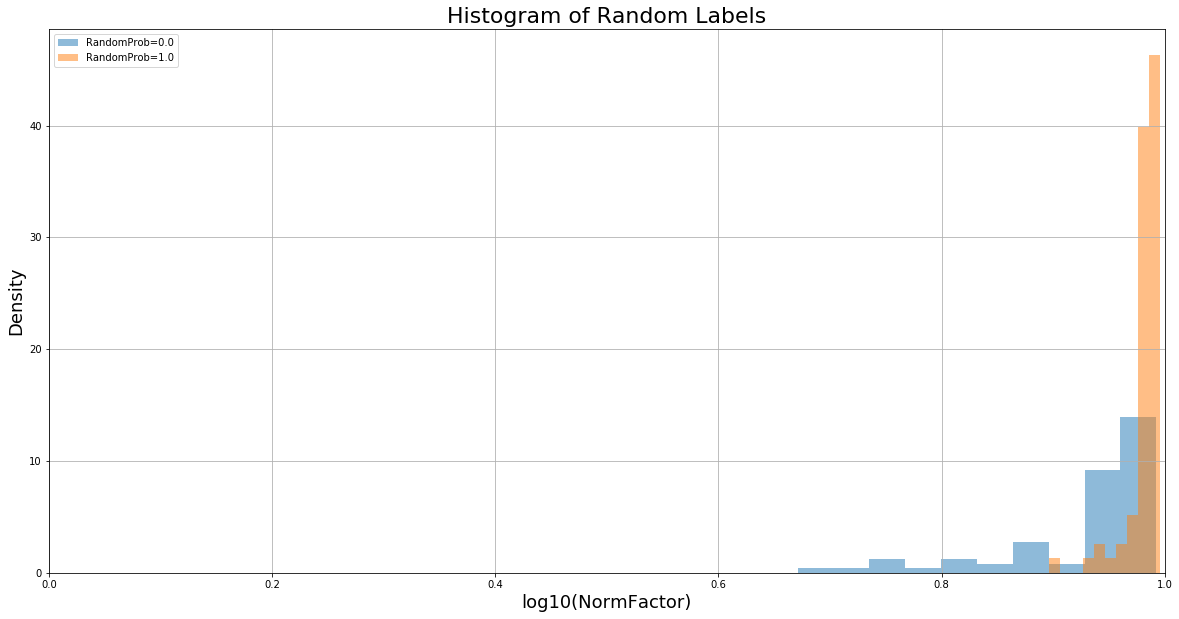

In [33]:
_, norm_factor_list_random_0, _, _, _  = get_NML_log_loss_from_dict(results_dict_Random_0)
_, norm_factor_list_random_7, _, _, _  = get_NML_log_loss_from_dict(results_dict_Random_7)
plt.figure(figsize=(20,10))
plt.hist(np.log10(norm_factor_list_random_0), alpha=0.5, label='RandomProb=0.0', density=True)
plt.hist(np.log10(norm_factor_list_random_7), alpha=0.5, label='RandomProb=1.0', density=True)
plt.legend()
plt.xlabel('log10(NormFactor)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title('Histogram of Random Labels', fontsize=22)
plt.xlim([0, 1])
plt.grid()

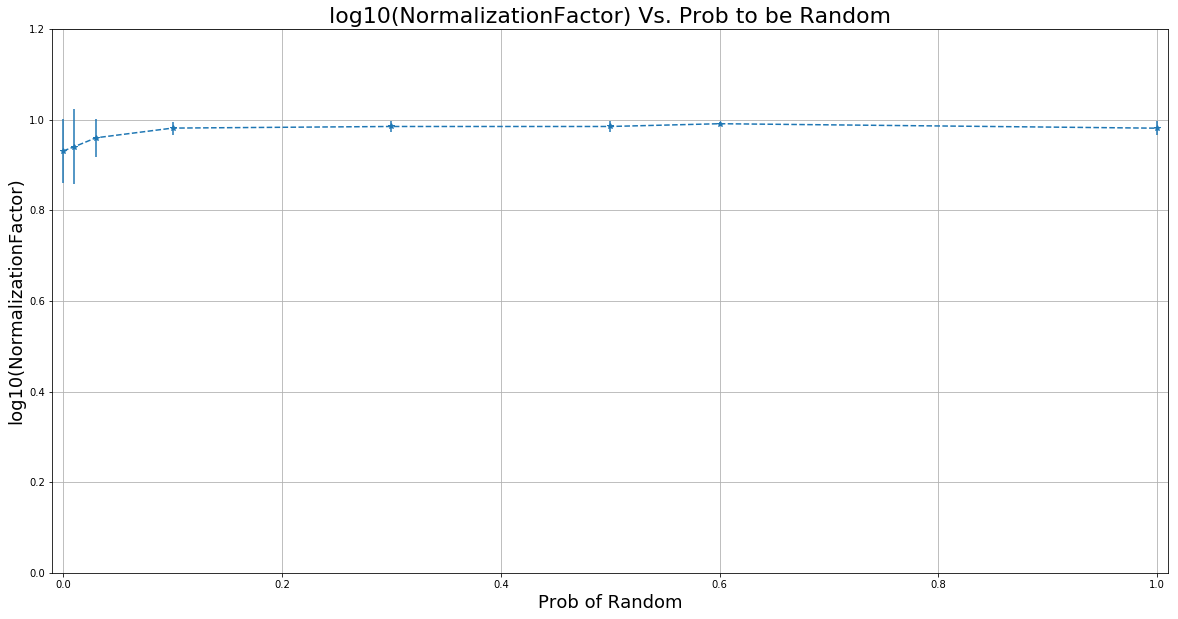

In [37]:
# Plot 
plt.figure(figsize=(20,10))
plt.errorbar(random_prob,  mean_log_norm_factor_list, yerr=std_log_norm_factor_list, fmt='--*',  label='NML')
plt.ylabel('log10(NormalizationFactor)', fontsize=18)
plt.xlabel('Prob of Random', fontsize=18)
plt.title('log10(NormalizationFactor) Vs. Prob to be Random', fontsize=22)
plt.ylim([0,1.2])
plt.xlim([-0.01,1.01])
plt.grid()
plt.show()

log10(NormalizationFactor) series: Prob2beRandom=[0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]=[  0.43    0.509   0.485   0.429   0.02    0.02   -1.043 -11.888]


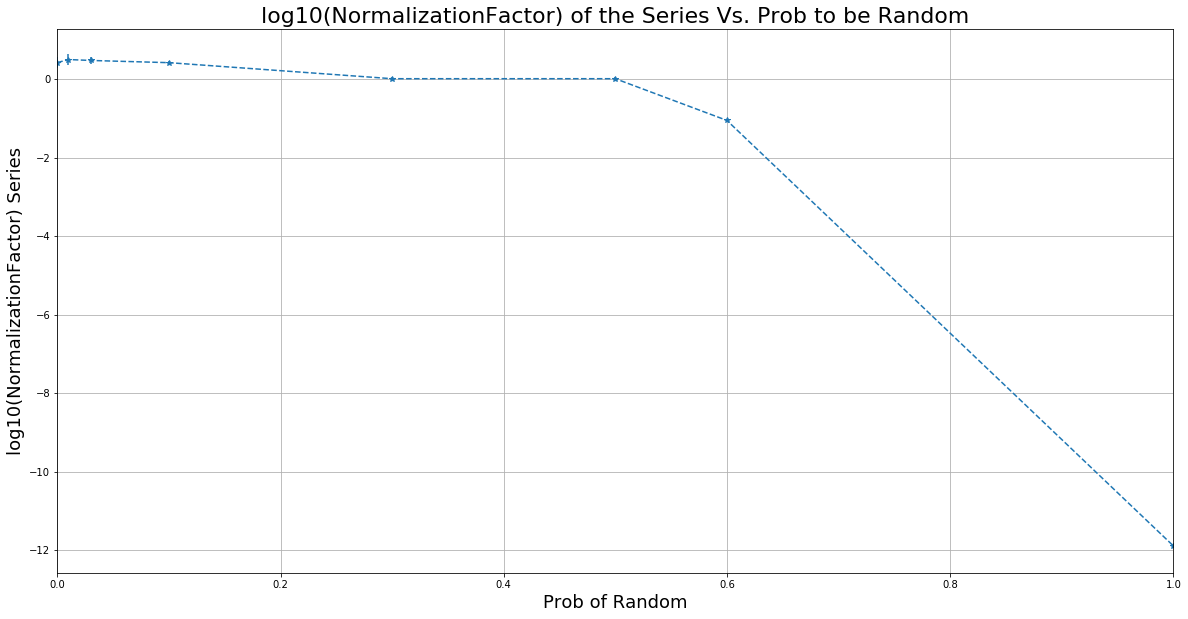

In [22]:
# Extract normalization factor of the series
result_dict_list = [results_dict_Random_0, results_dict_Random_1, results_dict_Random_2, results_dict_Random_3,
                    results_dict_Random_4, results_dict_Random_4, results_dict_Random_6, results_dict_Random_7]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
for results_dict in result_dict_list:
    _, norm_factor_list, _, _, _  = get_NML_log_loss_of_the_series_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())
print('log10(NormalizationFactor) series: Prob2beRandom={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))

# Figure 
plt.figure(figsize=(20,10))
plt.errorbar(random_prob,  mean_log_norm_factor_list, yerr=std_log_norm_factor_list, fmt='--*',  label='NML')
plt.ylabel('log10(NormalizationFactor) Series', fontsize=18)
plt.xlabel('Prob of Random', fontsize=18)
plt.title('log10(NormalizationFactor) of the Series Vs. Prob to be Random', fontsize=22)
# plt.ylim([0,1])
plt.xlim([0,1])
plt.grid()
plt.show()


# Training set subset

In [23]:
# #------
# # NML training set subset: training the model with reduce training set size

# # training set size 100
# files = ['../output/NML_trainset_subset_results_20180922_120302/results_NML_trainset_subset_20180922_120302.json'] # 0-99
# results_dict_trainingset_subset_0 = load_dict_from_file_list(files)
# print('trainingset_subset_100: loaded %d keys' % len(results_dict_trainingset_subset_0))

# # training set size 300
# files = ['../output/NML_trainset_subset_results_20180922_120325/results_NML_trainset_subset_20180922_120325.json'] # 0-99
# results_dict_trainingset_subset_1 = load_dict_from_file_list(files)
# print('trainingset_subset_300: loaded %d keys' % len(results_dict_trainingset_subset_1))

# # training set size 1,000
# files = ['../output/NML_trainset_subset_results_20180922_120401/results_NML_trainset_subset_20180922_120401.json'] # 0-99
# results_dict_trainingset_subset_2 = load_dict_from_file_list(files)
# print('trainingset_subset_1,000: loaded %d keys' % len(results_dict_trainingset_subset_2))

# # training set size 3,000
# files = ['../output/NML_trainset_subset_results_20180922_120758/results_NML_trainset_subset_20180922_120758.json'] # 0-99
# results_dict_trainingset_subset_3 = load_dict_from_file_list(files)
# print('trainingset_subset_3,000: loaded %d keys' % len(results_dict_trainingset_subset_3))

# # training set size 10,000
# files = ['../output/NML_trainset_subset_results_20180922_120524/results_NML_trainset_subset_20180922_120524.json'] # 0-99
# results_dict_trainingset_subset_4 = load_dict_from_file_list(files)
# print('trainingset_subset_10,000: loaded %d keys' % len(results_dict_trainingset_subset_4))

# # training set size 30,000
# files = ['../output/NML_trainset_subset_results_20180922_120521/results_NML_trainset_subset_20180922_120521.json'] # 0-99
# results_dict_trainingset_subset_5 = load_dict_from_file_list(files)
# print('trainingset_subset_30,000: loaded %d keys' % len(results_dict_trainingset_subset_5))

# # training set size 50,000
# files = ['../output/NML_trainset_subset_results_20180922_120421/results_NML_trainset_subset_20180922_120421.json'] # 0-99
# results_dict_trainingset_subset_6 = load_dict_from_file_list(files)
# print('trainingset_subset_50,000: loaded %d keys' % len(results_dict_trainingset_subset_6))

# trainset_size = [100, 300, 1000, 3000, 10000, 30000, 50000]
      
#------
# NML training set subset: training the model with reduce training set size: adjust sgd update

# training set size 100
files = ['../output/NML_trainset_subset_results_20180930_090805/results_NML_trainset_subset_20180930_090805.json'] # 0-99
results_dict_trainingset_subset_0 = load_dict_from_file_list(files)
print('trainingset_subset_100: loaded %d keys' % len(results_dict_trainingset_subset_0))

# training set size 500
files = ['../output/NML_trainset_subset_results_20180930_090815/results_NML_trainset_subset_20180930_090815.json'] # 0-99
results_dict_trainingset_subset_1 = load_dict_from_file_list(files)
print('trainingset_subset_500: loaded %d keys' % len(results_dict_trainingset_subset_1))

# training set size 1,000
files = ['../output/NML_trainset_subset_results_20180930_090837/results_NML_trainset_subset_20180930_090837.json'] # 0-99
results_dict_trainingset_subset_2 = load_dict_from_file_list(files)
print('trainingset_subset_1,000: loaded %d keys' % len(results_dict_trainingset_subset_2))

# training set size 5,000
files = ['../output/NML_trainset_subset_results_20180930_090840/results_NML_trainset_subset_20180930_090840.json'] # 0-99
results_dict_trainingset_subset_3 = load_dict_from_file_list(files)
print('trainingset_subset_5,000: loaded %d keys' % len(results_dict_trainingset_subset_3))

# training set size 10,000
files = ['../output/NML_trainset_subset_results_20180930_090905/results_NML_trainset_subset_20180930_090905.json'] # 0-99
results_dict_trainingset_subset_4 = load_dict_from_file_list(files)
print('trainingset_subset_10,000: loaded %d keys' % len(results_dict_trainingset_subset_4))

# training set size 12500
files = ['../output/NML_trainset_subset_results_20180930_090907/results_NML_trainset_subset_20180930_090907.json'] # 0-99
results_dict_trainingset_subset_5 = load_dict_from_file_list(files)
print('trainingset_subset_12,500: loaded %d keys' % len(results_dict_trainingset_subset_5))

# training set size 25,000
files = ['../output/NML_trainset_subset_results_20180930_090908/results_NML_trainset_subset_20180930_090908.json'] # 0-99
results_dict_trainingset_subset_6 = load_dict_from_file_list(files)
print('trainingset_subset_25,000: loaded %d keys' % len(results_dict_trainingset_subset_6))

# training set size 50,000
files = ['../output/NML_trainset_subset_results_20180930_090911/results_NML_trainset_subset_20180930_090911.json'] # 0-99
results_dict_trainingset_subset_7 = load_dict_from_file_list(files)
print('trainingset_subset_50,000: loaded %d keys' % len(results_dict_trainingset_subset_7))

trainset_size = [100, 500, 1000, 5000, 10000, 12500, 25000, 50000]

trainingset_subset_100: loaded 87 keys
trainingset_subset_500: loaded 86 keys
trainingset_subset_1,000: loaded 88 keys
trainingset_subset_5,000: loaded 87 keys
trainingset_subset_10,000: loaded 86 keys
trainingset_subset_12,500: loaded 84 keys
trainingset_subset_25,000: loaded 86 keys
trainingset_subset_50,000: loaded 84 keys


In [24]:
# Extract ormalization factor
result_dict_list = [results_dict_trainingset_subset_0, results_dict_trainingset_subset_1, 
                    results_dict_trainingset_subset_2, results_dict_trainingset_subset_3,
                    results_dict_trainingset_subset_4, results_dict_trainingset_subset_5, 
                    results_dict_trainingset_subset_6, results_dict_trainingset_subset_7]

# Extract the log normalization factor
mean_log_norm_factor_list = []
std_log_norm_factor_list = []
nml_mean_loss_list = []
nml_std_loss_list = []
nml_acc_list = []
for results_dict in result_dict_list:
    nml_loss, norm_factor_list, nml_acc, _, _  = get_NML_log_loss_from_dict(results_dict)
    mean_log_norm_factor_list.append(np.log10(norm_factor_list).mean())
    std_log_norm_factor_list.append(np.log10(norm_factor_list).std())
    nml_mean_loss_list.append(np.mean(nml_loss))
    nml_std_loss_list.append(np.std(nml_loss))
    nml_acc_list.append(nml_acc)
print('log10(NormalizationFactor): SubsetSize={}={}'.format(random_prob, np.round(mean_log_norm_factor_list,3)))

log10(NormalizationFactor): SubsetSize=[0.0, 0.01, 0.03, 0.1, 0.3, 0.5, 0.6, 1.0]=[0.413 0.882 0.324 0.149 0.606 0.433 0.572 0.096]


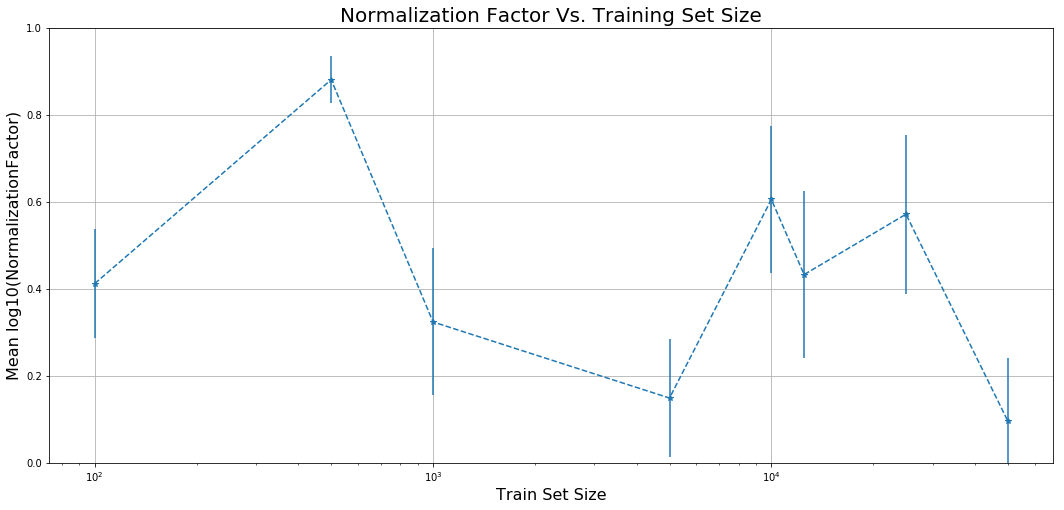

In [25]:
# Plot
plt.figure(figsize=(18,8))
plt.errorbar(trainset_size, mean_log_norm_factor_list, fmt='--*', yerr=std_log_norm_factor_list)
plt.xlabel('Train Set Size', fontsize=16)
plt.ylabel('Mean log10(NormalizationFactor)', fontsize=16)
plt.ylim([0, 1])
plt.xscale('log')
plt.title('Normalization Factor Vs. Training Set Size', fontsize=20)
plt.grid()
plt.show()

In [26]:
# Extract erm preformance
erm_mean_loss_list = []
erm_std_loss_list = []
erm_acc_list = []
for result_dict in result_dict_list:
    erm_loss, erm_acc, _ = get_ERM_log_loss_from_dict(result_dict)
    erm_mean_loss_list.append(np.mean(erm_loss))
    erm_std_loss_list.append(np.std(erm_loss))
    erm_acc_list.append(erm_acc)

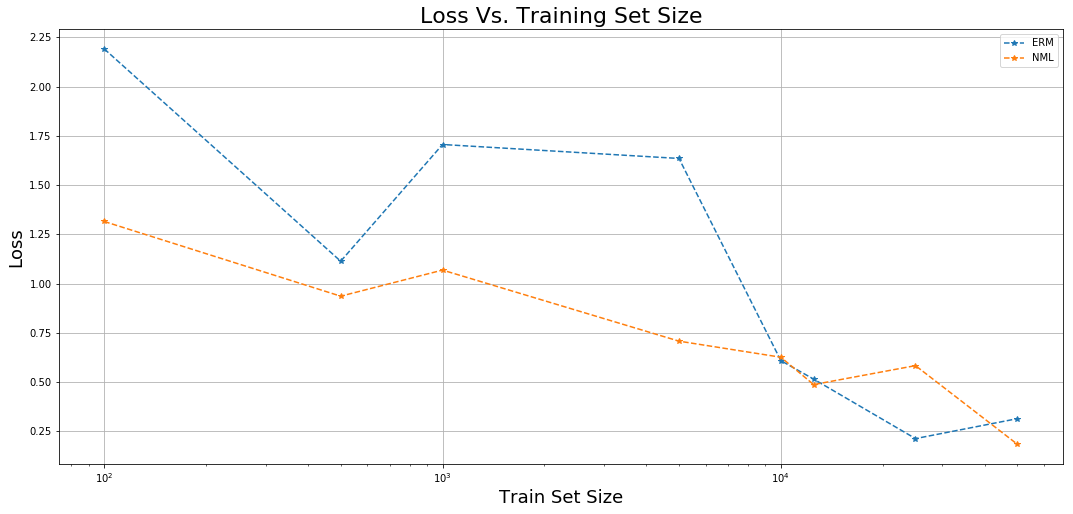

In [27]:
# Plot ERM vs NML Loss
plt.figure(figsize=(18,8))
plt.plot(trainset_size,  erm_mean_loss_list, '--*', label='ERM') # yerr=erm_std_loss_list, fmt='--*',  label='ERM')
plt.plot(trainset_size,  nml_mean_loss_list, '--*', label='NML')
plt.xlabel('Train Set Size', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xscale('log')
plt.title('Loss Vs. Training Set Size', fontsize=22)
plt.grid()
plt.legend()
plt.show()

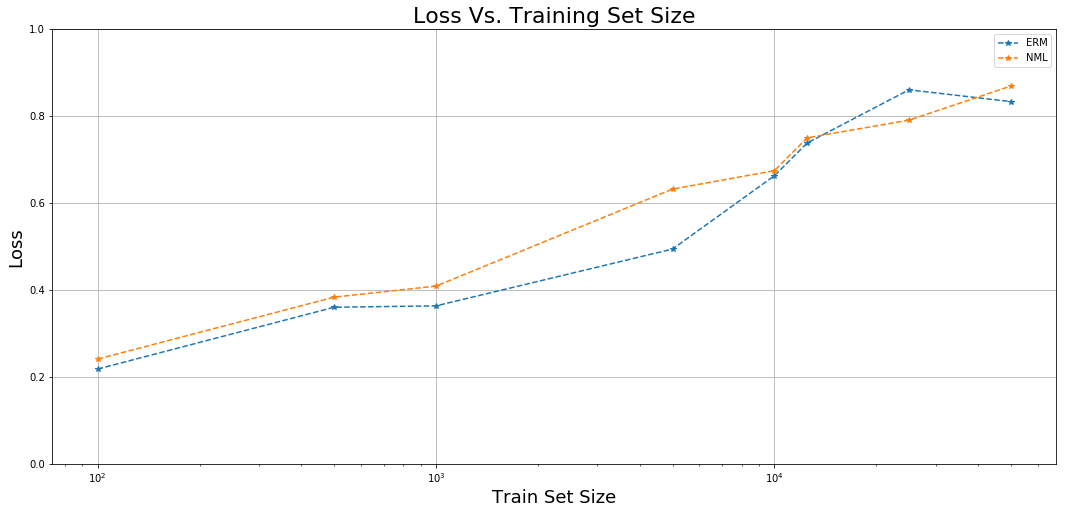

In [28]:
# Plot ERM vs NML Acc
plt.figure(figsize=(18,8))
plt.plot(trainset_size,  erm_acc_list, '--*', label='ERM') # yerr=erm_std_loss_list, fmt='--*',  label='ERM')
plt.plot(trainset_size,  nml_acc_list, '--*', label='NML')
plt.xlabel('Train Set Size', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xscale('log')
plt.ylim([0,1])
plt.title('Loss Vs. Training Set Size', fontsize=22)
plt.grid()
plt.legend()
plt.show()